<a href="https://colab.research.google.com/github/crystaljwang/tm10007_group_3/blob/preprocessing/feature_extraction_Crystal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading the GIST data from GitHub

In [1]:
# Run this to use from colab environment
!pip install -q --upgrade git+https://github.com/jveenland/tm10007_ml.git

  Preparing metadata (setup.py) ... done


In [2]:
# Run this to use from colab environment
!git clone https://github.com/jveenland/tm10007_ml.git

fatal: destination path 'tm10007_ml' already exists and is not an empty directory.


In [3]:
%cd /content/tm10007_ml/worcgist

/content/tm10007_ml/worcgist


In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np

from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold

In [5]:
dir = Path('.') / 'GIST_radiomicFeatures.csv'
data = pd.read_csv(dir, index_col=0)

print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')
data.info()

The number of samples: 246
The number of columns: 494
<class 'pandas.core.frame.DataFrame'>
Index: 246 entries, GIST-001_0 to GIST-246_0
Columns: 494 entries, label to PREDICT_original_phasef_phasesym_entropy_WL3_N5
dtypes: float64(468), int64(25), object(1)
memory usage: 951.3+ KB


Splitting the data

In [6]:
# ----- SPLITTING THE DATA -----

# Replace label values from string to binary
data['label'] = data['label'].replace({'GIST': 1, 'non-GIST': 0})

# Separate the features and labels
X = data.drop(['label'], axis=1)
y = data['label']

# Split the data into random train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)

(196, 493)
(50, 493)


Preprocessing

In [7]:
# ----- PREPROCESSING -----

# Data scaling
X_train = StandardScaler().fit_transform(X_train)

Feature selection

In [8]:
# ----- FEATURE SELECTION -----

# Remove all constant (zero-variance) features
X_train = pd.DataFrame(X_train)

zero_var_filter = VarianceThreshold(threshold=0)
zero_var_filter.fit(X_train)
zero_var_columns = [column for column in X_train.columns if column not in X_train.columns[zero_var_filter.get_support()]]
X_new = zero_var_filter.transform(X_train)

removed_features = [data.columns[index] for index in zero_var_columns]
print('The following constant features were removed:')
for feature in removed_features:
    print(f'- {feature}')

The following constant features were removed:
- PREDICT_original_tf_LBP_min_R3_P12
- PREDICT_original_tf_LBP_kurtosis_R3_P12
- PREDICT_original_tf_LBP_peak_R3_P12
- PREDICT_original_tf_LBP_min_R8_P24
- PREDICT_original_tf_LBP_peak_R8_P24
- PREDICT_original_tf_LBP_min_R15_P36
- PREDICT_original_tf_LBP_peak_R15_P36
- PREDICT_original_phasef_monogenic_entropy_WL3_N5
- PREDICT_original_phasef_phasecong_kurtosis_WL3_N5
- PREDICT_original_phasef_phasecong_peak_WL3_N5
- PREDICT_original_phasef_phasecong_entropy_WL3_N5
- PREDICT_original_phasef_phasesym_kurtosis_WL3_N5
- PREDICT_original_phasef_phasesym_peak_WL3_N5


Feature selection test: Recursive Feature Elimination (RFE).

This method eliminates the least important feature after recursively training. By default, the numer of features selected is the median of the total features

In [9]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# Select the best important features according to Logistic Regression
rfe_selector = RFE(estimator=LogisticRegression(max_iter=1000), step=1)
rfe_selector.fit(X_new,y_train)

data_new = data.drop(data.columns[zero_var_columns], axis=1)
del data_new[data_new.columns[0]]
X_new = pd.DataFrame(X_new)

print(rfe_selector.get_support())
rfe_list = X_new.columns[rfe_selector.get_support()]
print(rfe_list)
#X_rfe = rfe_selector.transform(X_new)

[ True  True False  True  True False False False  True False  True False
  True  True  True  True False  True False  True False  True  True False
 False  True False False  True  True  True False  True  True False False
  True False  True  True False  True  True  True False False  True False
 False  True False False False  True  True False  True  True  True False
 False  True  True False False  True False  True  True False  True  True
 False False  True  True False False  True  True False  True False False
  True False  True False False  True  True  True False  True  True  True
 False False False False False False  True False False  True False False
 False False False False False False False False  True  True  True False
 False False  True False False  True  True False False False  True False
 False False False False False False False False  True  True False  True
  True  True False False False False  True False False False False False
 False False False False False False False False Fa

Feature selection test: SelectFromModel.

This method is based on the importance attribute. By default, features with an importance attribute above the mean (threshold) are selected.

In [10]:
from sklearn.feature_selection import SelectFromModel

# Select the best important features according to Logistic Regression using SelectFromModel
sfm_selector = SelectFromModel(estimator=LogisticRegression(max_iter=1000))
sfm_selector.fit(X_new, y_train)

sfm_list = X_new.columns[sfm_selector.get_support()]
print(sfm_list)

Int64Index([  0,   1,   3,   4,   8,  10,  13,  15,  17,  19,
            ...
            462, 464, 465, 467, 469, 470, 471, 472, 473, 476],
           dtype='int64', length=181)


Feature selection test: Recursive feature elimination with cross-validation.

This method uses automatic tuning of the number of features selected with cross-validation. Here, a stratified 5-fold cross-validation is used. From the plot of the number of features versus the cross-validation scores, the test accuracy is shown and a plateau of equivalent scores is noticed.

In [11]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression

min_features_to_select = 1  # Minimum number of features to consider
clf = LogisticRegression(max_iter=1000)
cv = StratifiedKFold(5)

rfecv = RFECV(
    estimator=clf,
    step=1,
    cv=cv,
    scoring="accuracy",
    min_features_to_select=min_features_to_select,
    n_jobs=2,
)
rfecv.fit(X_new, y_train)

print(f"Optimal number of features: {rfecv.n_features_}")

Optimal number of features: 251


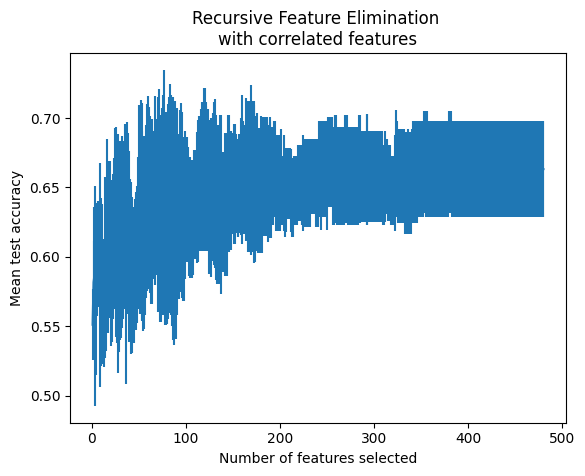

In [12]:
import matplotlib.pyplot as plt

n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(min_features_to_select, n_scores + min_features_to_select),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

Feature selection method: SelectKBest.

This method selects features according to the 10 highest scores using f_classif.

In [13]:
# Select features according to the k highest scores
kbest_filter = SelectKBest(f_classif, k=10)
kbest_filter.fit(X_new, y_train)

data_new = data.drop(data.columns[zero_var_columns], axis=1)
del data_new[data_new.columns[0]]
kbest_list = kbest_filter.get_feature_names_out(input_features=data_new.columns)

print('The selected 10 best features are:')
for kbest in kbest_list:
    print(f'- {kbest}')

X_kbest = kbest_filter.transform(X_new)

The selected 10 best features are:
- PREDICT_original_tf_GLCMMS_homogeneityd3.0A0.0mean
- PREDICT_original_tf_GLCMMS_homogeneityd3.0A0.0std
- PREDICT_original_tf_GLCMMS_homogeneityd3.0A0.79mean
- PREDICT_original_tf_GLCMMS_homogeneityd3.0A0.79std
- PREDICT_original_tf_GLCMMS_homogeneityd3.0A1.57mean
- PREDICT_original_tf_GLCMMS_homogeneityd3.0A1.57std
- PREDICT_original_tf_GLCMMS_homogeneityd3.0A2.36mean
- PREDICT_original_tf_GLCMMS_homogeneityd3.0A2.36std
- PREDICT_original_tf_Gabor_mean_F0.2_A0.79
- PREDICT_original_tf_Gabor_mean_F0.5_A0.79


In [14]:
X_kbest.shape

(196, 10)